In [4]:
import os
import subprocess

In [6]:

# Check if the repository has already been cloned
repo_name = "Digital-Egypt-Pioneers-Initiative-DEPI-"

if os.path.exists(repo_name):
        print(f"Repository '{repo_name}' already exists. Pulling latest changes.")
        subprocess.run(['git', '-C', "Digital-Egypt-Pioneers-Initiative-DEPI-", 'pull'], check=True)
else:
        print(f"Cloning repository '{repo_name}'.")
        subprocess.run(['git', 'clone', "Digital-Egypt-Pioneers-Initiative-DEPI-"], check=True)



Repository 'Digital-Egypt-Pioneers-Initiative-DEPI-' already exists. Pulling latest changes.


In [7]:
# Change directory to the desired folder
target_dir = os.path.join(repo_name, 'Microsoft_Malware_Kaagle')

if os.path.exists(target_dir):
        os.chdir(target_dir)
        print(f"Changed directory to {target_dir}.")
else:
        print(f"Target directory '{target_dir}' not found.")

Changed directory to Digital-Egypt-Pioneers-Initiative-DEPI-/Microsoft_Malware_Kaagle.


In [8]:
from google.colab import files


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

from utils import *


In [ ]:
! pip install -q kaggle
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c microsoft-malware-prediction

! unzip "microsoft-malware-prediction.zip"

Saving kaggle.json to kaggle (1).json
 99% 1.53G/1.54G [00:23<00:00, 102MB/s]
100% 1.54G/1.54G [00:23<00:00, 71.4MB/s]
Archive:  microsoft-malware-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Step1: EDA

In [10]:
train_data = load_random_sample('train.csv', sample_size=10000)


/content/Digital-Egypt-Pioneers-Initiative-DEPI-/Microsoft_Malware_Kaagle/utils.py:77: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  random_sample = pd.read_csv(file_path, skiprows=skip_rows)


In [ ]:
train_data.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0001e88bd9d4aba16856e65b72250eec,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1051.0,0,5.0,0,NaN,3371.0,...,33094.0,1,0.0,0.0,1,0,0.0,0.0,3.0,0
1,0001fb125bdfaf430a5d7051da7cc04e,win8defender,1.1.15100.1,4.18.1807.18075,1.273.810.0,0,7.0,0,NaN,53447.0,...,64721.0,0,0.0,0.0,0,0,0.0,0.0,3.0,1
2,000f7447263d2f8bbbc1dc2c2ef1384b,win8defender,1.1.15100.1,4.11.15063.447,1.273.658.0,0,7.0,0,NaN,43179.0,...,33142.0,0,0.0,0.0,0,0,0.0,1.0,5.0,0
3,00105240b273a85492bdd818570ad66f,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1555.0,0,7.0,0,NaN,53447.0,...,58369.0,0,NaN,0.0,0,0,0.0,0.0,6.0,1
4,0010893e32f70bc2457d42754c581ab9,win8defender,1.1.14202.0,4.13.17134.1,1.253.85.0,0,7.0,0,146.0,58237.0,...,43240.0,0,NaN,0.0,0,0,0.0,0.0,15.0,0


In [111]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 83 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MachineIdentifier                                  10000 non-null  int16  
 1   ProductName                                        10000 non-null  int8   
 2   EngineVersion                                      10000 non-null  int8   
 3   AppVersion                                         10000 non-null  int8   
 4   AvSigVersion                                       10000 non-null  int16  
 5   IsBeta                                             10000 non-null  int8   
 6   RtpStateBitfield                                   9967 non-null   float64
 7   IsSxsPassiveMode                                   10000 non-null  int8   
 8   DefaultBrowsersIdentifier                          478 non-null    float64
 9   AVProdu

In [ ]:
num_features = train_data.shape[1]
print(f"Number of features: {num_features}")
training_examples = train_data.shape[0]
print(f"Number of training examples: {training_examples}")

Number of features: 83
Number of training examples: 10000


In [ ]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
IsBeta,10000.0,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.000000e+00,0.000000e+00
RtpStateBitfield,9967.0,6.852112e+00,1.003206e+00,0.0,7.00,7.0,7.000000e+00,8.000000e+00
IsSxsPassiveMode,10000.0,1.580000e-02,1.247073e-01,0.0,0.00,0.0,0.000000e+00,1.000000e+00
DefaultBrowsersIdentifier,478.0,1.661019e+03,1.010742e+03,132.0,788.00,1703.0,2.388000e+03,3.195000e+03
AVProductStatesIdentifier,9950.0,4.777557e+04,1.401940e+04,901.0,49480.00,53447.0,5.344700e+04,7.026200e+04
AVProductsInstalled,9950.0,1.324824e+00,5.205756e-01,1.0,1.00,1.0,2.000000e+00,5.000000e+00
AVProductsEnabled,9950.0,1.020804e+00,1.661631e-01,0.0,1.00,1.0,1.000000e+00,3.000000e+00
HasTpm,10000.0,9.872000e-01,1.124163e-01,0.0,1.00,1.0,1.000000e+00,1.000000e+00
CountryIdentifier,10000.0,1.085019e+02,6.281606e+01,1.0,51.00,97.0,1.620000e+02,2.220000e+02
CityIdentifier,9652.0,8.266856e+04,4.871995e+04,41.0,38836.25,84158.0,1.252910e+05,1.679070e+05


In [13]:
cat_cols = get_categorical_columns_with_few_unique_values(train_data,10)
print(f"Categorical columns with few unique values: {cat_cols}")

Categorical columns with fewer than 10 unique values:
Column: 'ProductName'
Number of unique values: 2
Unique values: ['win8defender' 'mse']
---------------------------------------------------------------------------------------------------- 

Column: 'Platform'
Number of unique values: 4
Unique values: ['windows10' 'windows8' 'windows2016' 'windows7']
---------------------------------------------------------------------------------------------------- 

Column: 'Processor'
Number of unique values: 2
Unique values: ['x64' 'x86']
---------------------------------------------------------------------------------------------------- 

Column: 'OsVer'
Number of unique values: 4
Unique values: ['10.0.0.0' '6.3.0.0' '6.1.1.0' '10.0.3.0']
---------------------------------------------------------------------------------------------------- 

Column: 'OsPlatformSubRelease'
Number of unique values: 9
Unique values: ['rs4' 'rs3' 'rs2' 'th1' 'th2' 'rs1' 'windows8.1' 'prers5' 'windows7']
--------------

In [ ]:

# Create the DataFrame with missing values summary
missing_values_summary = pd.DataFrame({
    'Total No. of Missing Values': train_data.isnull().sum(),
    'Percentage of Missing Values': (train_data.isnull().sum() / len(train_data)) * 100
})

# Display the DataFrame
display(missing_values_summary)

,Total No. of Missing Values,Percentage of Missing Values
MachineIdentifier,0,0.00
ProductName,0,0.00
EngineVersion,0,0.00
AppVersion,0,0.00
AvSigVersion,0,0.00
...,...,...
Census_IsPenCapable,0,0.00
Census_IsAlwaysOnAlwaysConnectedCapable,99,0.99
Wdft_IsGamer,330,3.30
Wdft_RegionIdentifier,330,3.30


In [ ]:
train_data_cleaned = clean_and_impute_data(train_data, cat_features_idx, num_features_idx)


Dropped features with more than 50% missing values:
['DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled']
New DataFrame shape: (10000, 79)


In [ ]:
print("Memory usage before optimization:")
print(train_data.memory_usage(deep=True))

# After type casting
optimized_data = downcast_numerical(train_data)
optimized_data = encode_categorical(train_data)

print("Memory usage after optimization:")
print(optimized_data.memory_usage(deep=True))


Memory usage before optimization:
Index                                         128
MachineIdentifier                          890000
ProductName                                689019
EngineVersion                              679999
AppVersion                                 715410
                                            ...  
Census_IsPenCapable                         80000
Census_IsAlwaysOnAlwaysConnectedCapable     80000
Wdft_IsGamer                                80000
Wdft_RegionIdentifier                       80000
HasDetections                               80000
Length: 84, dtype: int64
Memory usage after optimization:
Index                                        128
MachineIdentifier                          20000
ProductName                                10000
EngineVersion                              10000
AppVersion                                 10000
                                           ...  
Census_IsPenCapable                        10000
Census_IsAlways

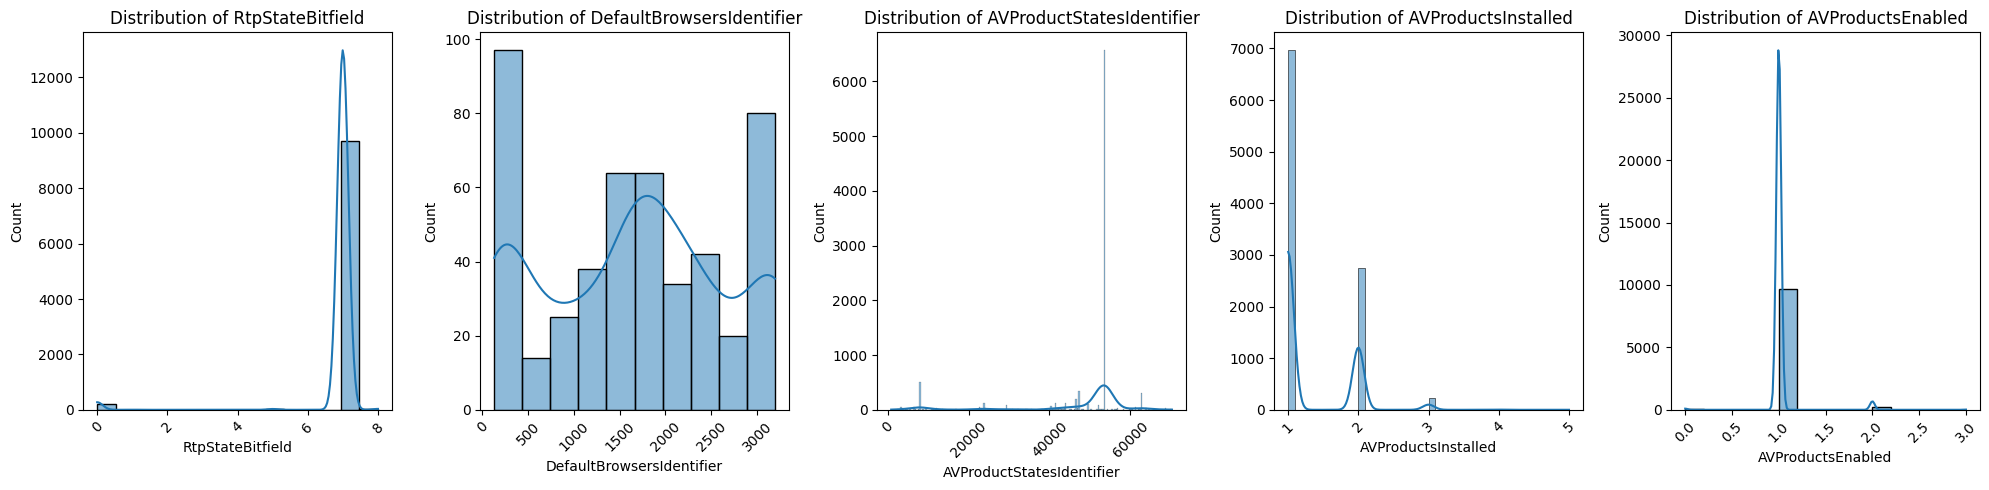

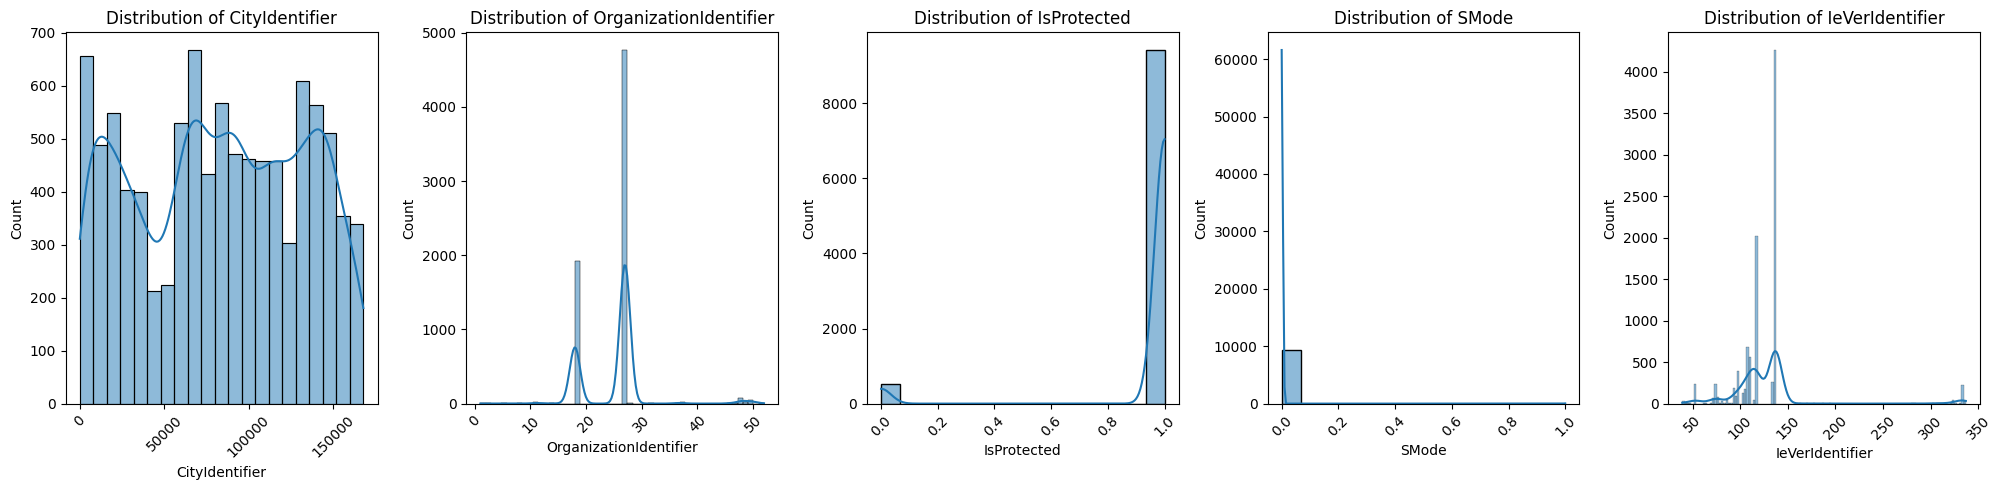

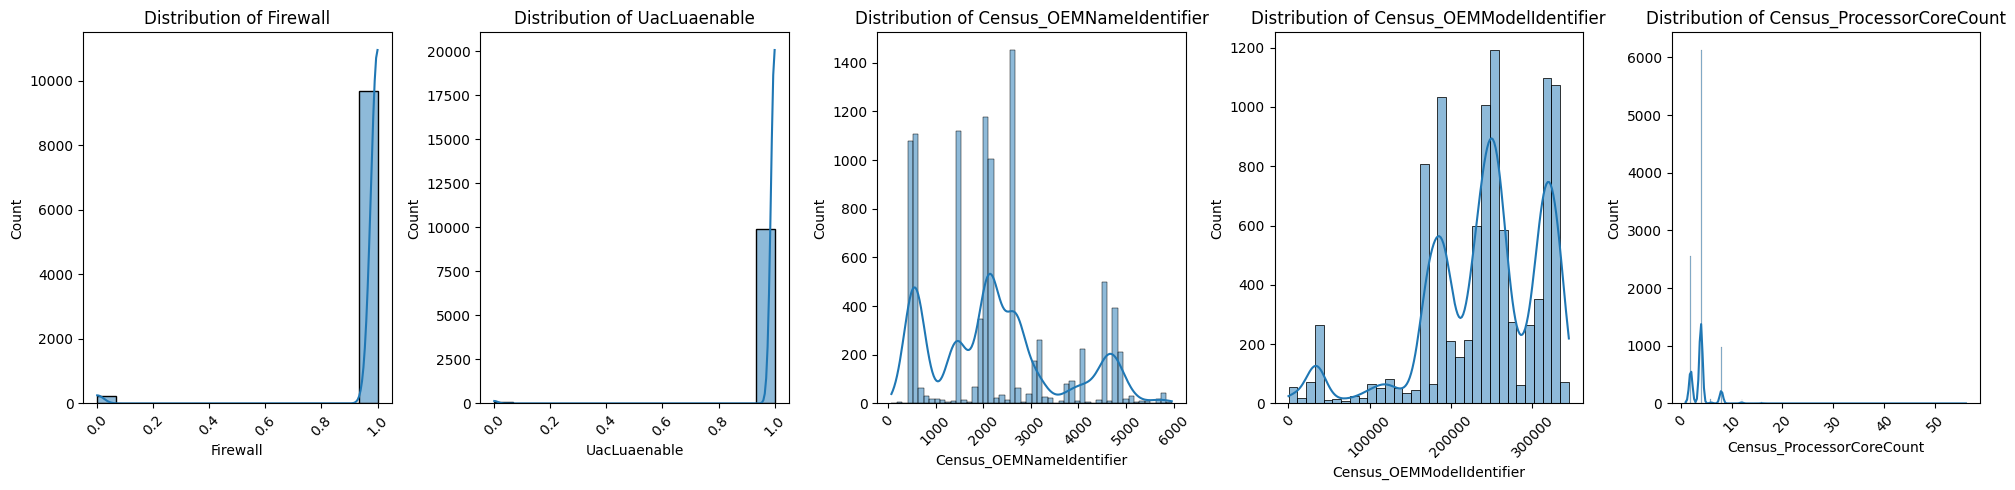

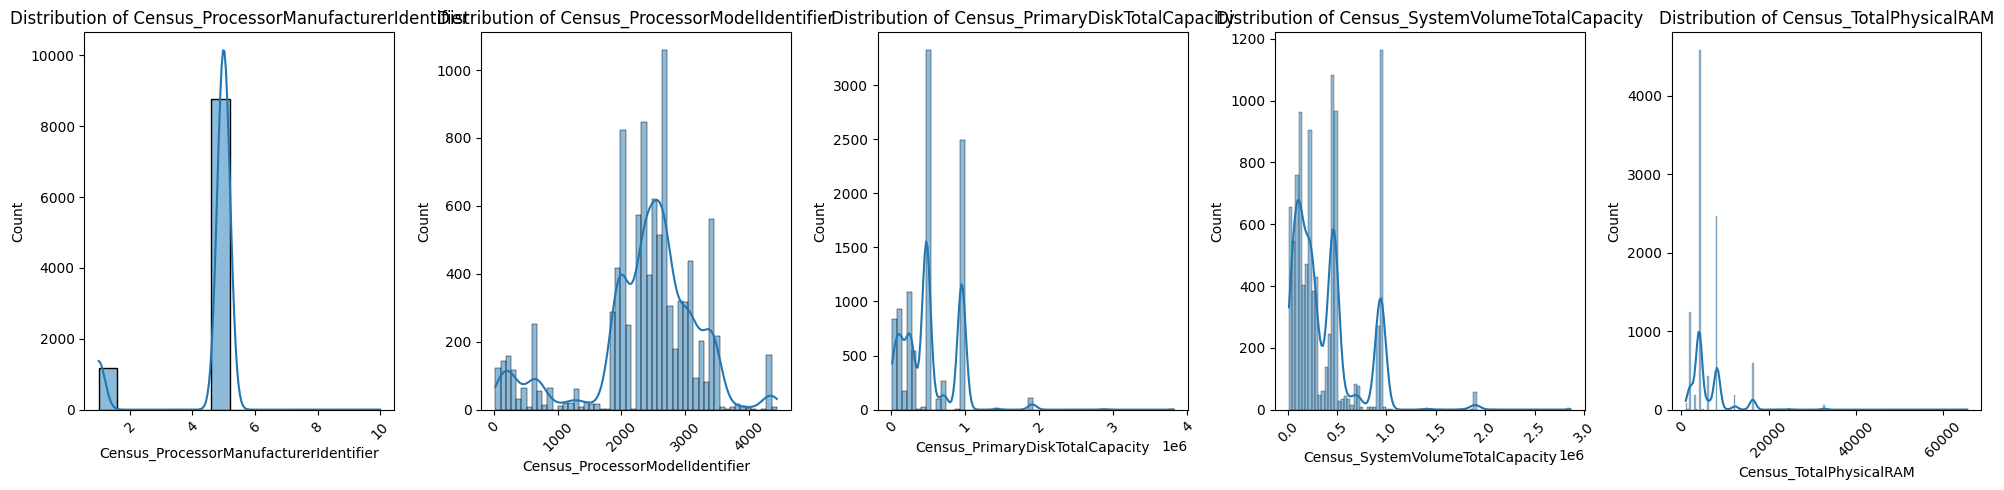

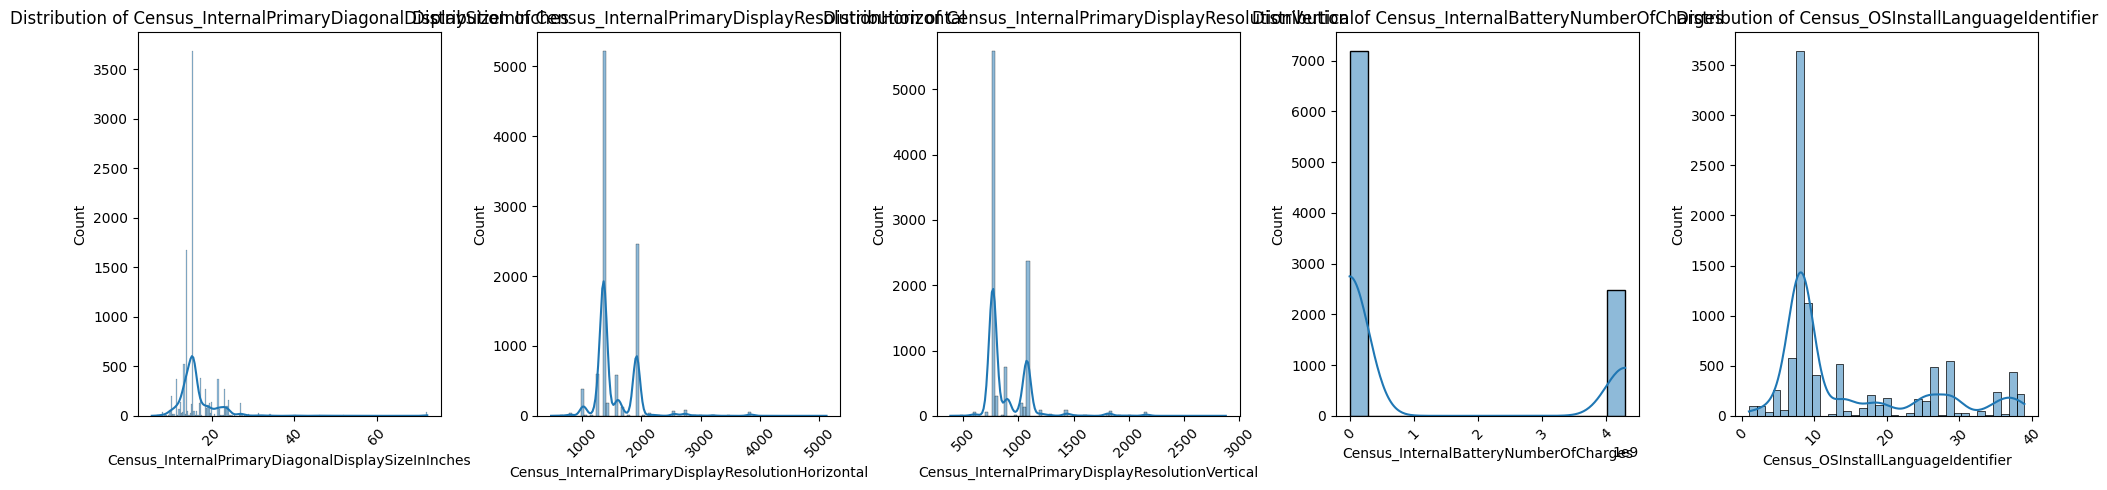

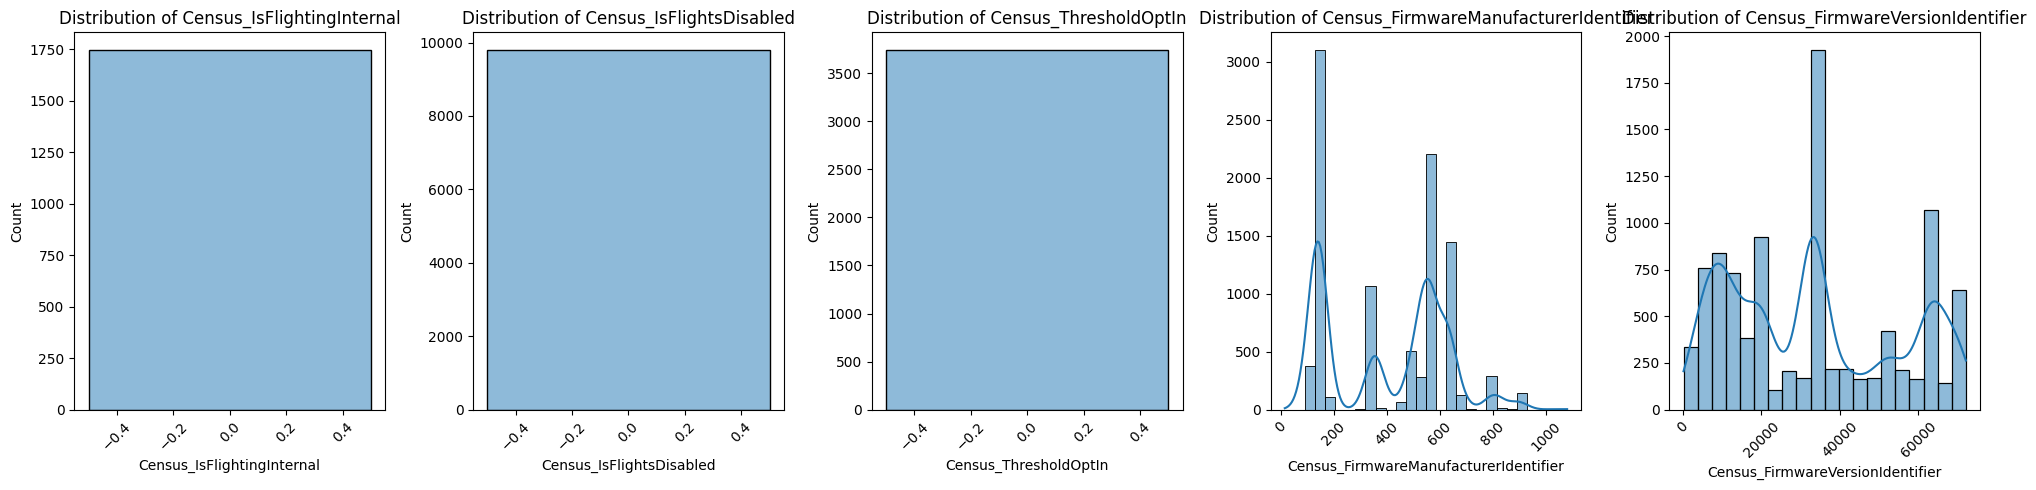

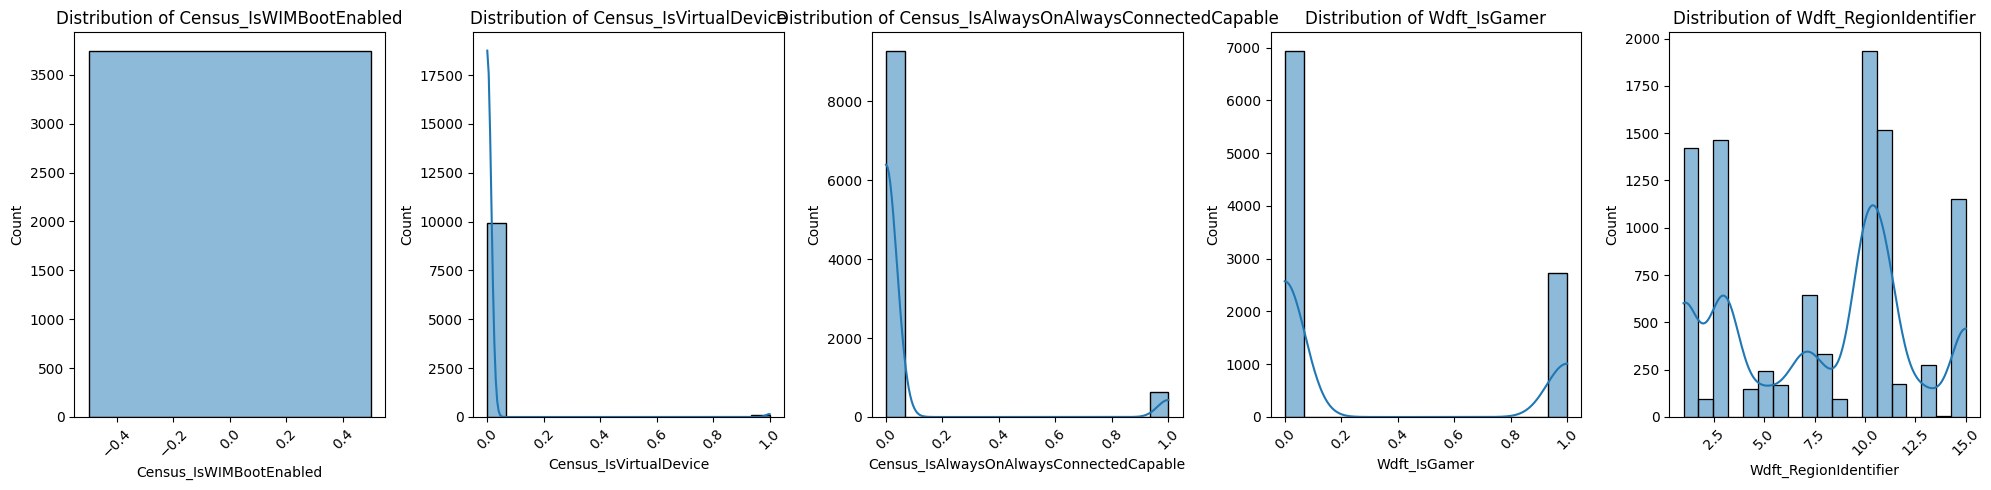

In [ ]:
# Usage
plot_numerical_features(train_data)


In [ ]:
train_data['Census_IsFlightsDisabled'].unique()

array([ 0., nan])